In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import xgboost as xgb

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

# Load the merged dataset
data = pd.read_csv('FR_alltraits_sites_merged.csv')

print(f"Dataset shape: {data.shape}")
print(f"\nColumn names:")
print(data.columns.tolist())
print(f"\nFirst few rows:")
display(data.head())

print(f"\nDataset info:")
print(data.info())

print(f"\nMissing values:")
print(data.isnull().sum())

Libraries imported successfully!
Dataset shape: (700, 12)

Column names:
['SiteLatitude', 'SiteLongitude', 'CWM_Rr25_Tj2001', 'CWM_RD', 'CWM_SRL', 'CWM_RTD', 'CWM_Exudation', 'root_dep.value', 'olp.value', 'z_cost.value', 'ph.value', 'cn.value']

First few rows:


,SiteLatitude,SiteLongitude,CWM_Rr25_Tj2001,CWM_RD,CWM_SRL,CWM_RTD,CWM_Exudation,root_dep.value,olp.value,z_cost.value,ph.value,cn.value
0,-35.3500,148.9333,14.952300,0.639228,48.507434,0.291759,93.758785,4014.679688,15.944540,15.820678,5.584140,9.199300
1,-4.0000,12.0000,3.267682,0.704641,48.942450,0.236690,94.456586,16486.290160,3.000000,12.496246,5.023036,10.131575
2,0.2800,117.1200,5.707757,0.709774,47.181029,0.250382,94.236728,2661.281250,4.120641,12.964827,5.092720,10.436300
3,2.9667,102.3000,6.850000,0.698580,47.534662,0.256253,93.955502,3983.571655,1.912674,15.474909,5.113865,10.135500
4,13.7500,100.5200,5.748991,0.703597,47.732275,0.248641,94.847809,9287.255127,3.500000,40.574192,5.168400,12.584100



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SiteLatitude     699 non-null    float64
 1   SiteLongitude    699 non-null    float64
 2   CWM_Rr25_Tj2001  700 non-null    float64
 3   CWM_RD           700 non-null    float64
 4   CWM_SRL          700 non-null    float64
 5   CWM_RTD          700 non-null    float64
 6   CWM_Exudation    700 non-null    float64
 7   root_dep.value   699 non-null    float64
 8   olp.value        699 non-null    float64
 9   z_cost.value     699 non-null    float64
 10  ph.value         699 non-null    float64
 11  cn.value         699 non-null    float64
dtypes: float64(12)
memory usage: 65.8 KB
None

Missing values:
SiteLatitude       1
SiteLongitude      1
CWM_Rr25_Tj2001    0
CWM_RD             0
CWM_SRL            0
CWM_RTD            0
CWM_Exudation      0
root_dep.value     1
olp.

Clean dataset shape: (699, 12)
Features shape: (699, 9)
Target shape: (699,)

Target variable (z_cost) statistics:
count    699.000000
mean      14.028263
std        6.640505
min        5.028873
25%        9.293697
50%       12.451325
75%       16.834806
max       44.406540
Name: z_cost.value, dtype: float64


Text(0, 0.5, 'Frequency')

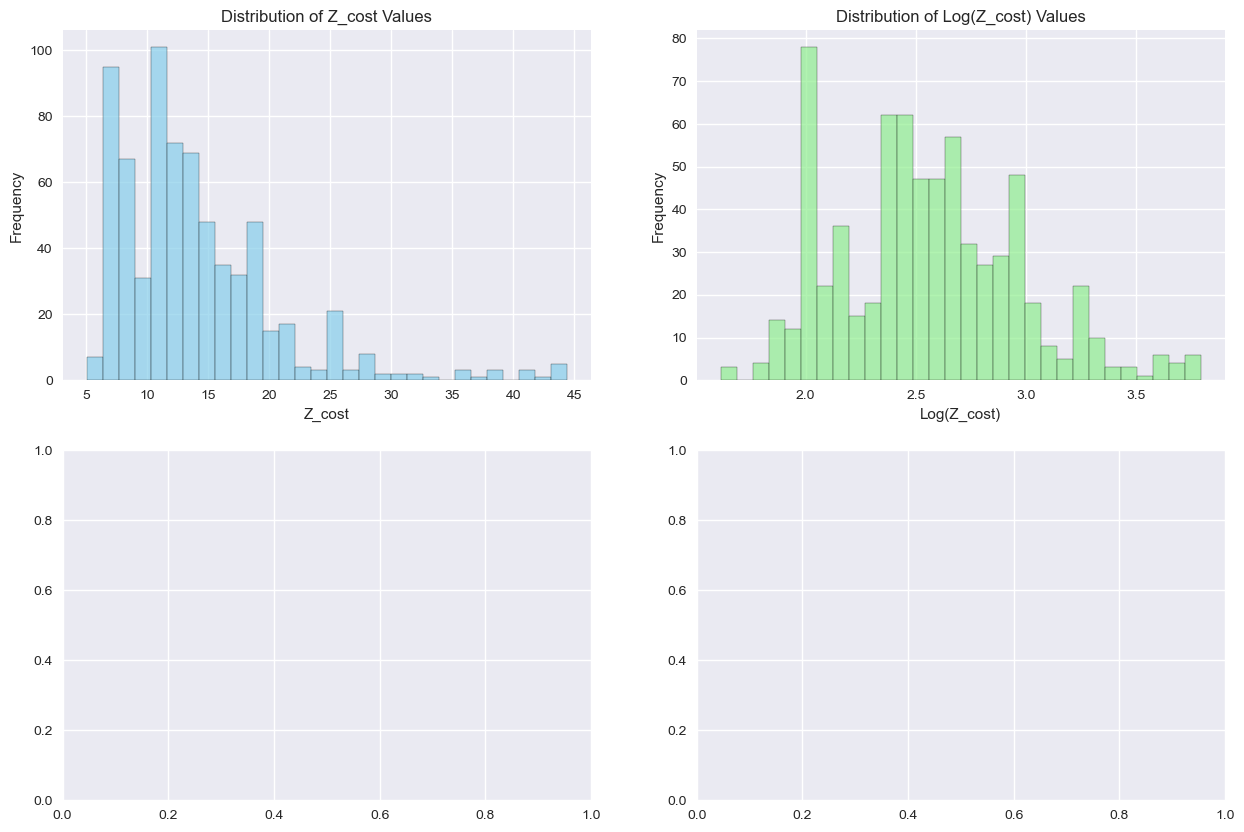

In [25]:
# Data preprocessing
# Remove rows with missing values
data_clean = data.dropna()
print(f"Clean dataset shape: {data_clean.shape}")

# Define target variable and predictor variables
target = 'z_cost.value'
predictors = ['CWM_Rr25_Tj2001', 'CWM_RD', 'CWM_SRL', 'CWM_RTD', 'CWM_Exudation', 'root_dep.value', 'olp.value', 'ph.value', 'cn.value']

# Extract features and target
X = data_clean[predictors]
y = data_clean[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Basic statistics
print(f"\nTarget variable (z_cost) statistics:")
print(y.describe())

# Exploratory Data Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of target variable
axes[0,0].hist(y, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Z_cost Values')
axes[0,0].set_xlabel('Z_cost')
axes[0,0].set_ylabel('Frequency')

# Log distribution of target variable
axes[0,1].hist(np.log(y), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribution of Log(Z_cost) Values')
axes[0,1].set_xlabel('Log(Z_cost)')
axes[0,1].set_ylabel('Frequency')

In [26]:
# Correlation heatmap
correlation_matrix = X.corr()
im = axes[1,0].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1,0].set_xticks(range(len(predictors)))
axes[1,0].set_yticks(range(len(predictors)))
axes[1,0].set_xticklabels(predictors, rotation=45, ha='right')
axes[1,0].set_yticklabels(predictors)
axes[1,0].set_title('Feature Correlation Matrix')
plt.colorbar(im, ax=axes[1,0])

# Target vs most correlated feature
correlations_with_target = X.corrwith(y).abs().sort_values(ascending=False)
most_correlated = correlations_with_target.index[0]
axes[1,1].scatter(X[most_correlated], y, alpha=0.6, color='coral')
axes[1,1].set_xlabel(most_correlated)
axes[1,1].set_ylabel('Z_cost')
axes[1,1].set_title(f'Z_cost vs {most_correlated} (r={correlations_with_target.iloc[0]:.3f})')

plt.tight_layout()
plt.savefig('eda_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelations with target variable (z_cost):")
print(correlations_with_target.sort_values(ascending=False))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

<Figure size 800x550 with 0 Axes>


Correlations with target variable (z_cost):
cn.value           0.229316
olp.value          0.186552
root_dep.value     0.090679
CWM_Exudation      0.052956
CWM_Rr25_Tj2001    0.046147
CWM_SRL            0.043723
ph.value           0.036248
CWM_RD             0.014256
CWM_RTD            0.013436
dtype: float64
Training set shape: (559, 9)
Test set shape: (140, 9)


In [27]:
# Scale the features (optional for XGBoost but good for comparison with other models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=predictors, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=predictors, index=X_test.index)

# XGBoost Model - Initial Training
print("Training initial XGBoost model...")

# Create XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    subsample=0.8,
    colsample_bytree=0.8
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"\nInitial XGBoost Model Performance:")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Training initial XGBoost model...

Initial XGBoost Model Performance:
Training R²: 0.9875
Test R²: 0.5485
Training RMSE: 0.7541
Test RMSE: 4.1522
Training MAE: 0.5508
Test MAE: 2.9169


In [28]:
# Hyperparameter tuning for XGBoost
print("Performing hyperparameter tuning...")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 6],
    'subsample': [0.8, 0.9, 1.0]
}

# Grid search with cross-validation
xgb_grid = GridSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)

print(f"\nBest parameters: {xgb_grid.best_params_}")
print(f"Best cross-validation score: {xgb_grid.best_score_:.4f}")

# Train best model
best_xgb_model = xgb_grid.best_estimator_
y_pred_train_best = best_xgb_model.predict(X_train)
y_pred_test_best = best_xgb_model.predict(X_test)

# Calculate metrics for best model
best_train_r2 = r2_score(y_train, y_pred_train_best)
best_test_r2 = r2_score(y_test, y_pred_test_best)
best_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_best))
best_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_best))

print(f"\nBest XGBoost Model Performance:")
print(f"Training R²: {best_train_r2:.4f}")
print(f"Test R²: {best_test_r2:.4f}")
print(f"Training RMSE: {best_train_rmse:.4f}")
print(f"Test RMSE: {best_test_rmse:.4f}")

Performing hyperparameter tuning...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation score: 0.3404

Best XGBoost Model Performance:
Training R²: 0.9533
Test R²: 0.5917
Training RMSE: 1.4574
Test RMSE: 3.9486


In [29]:
# Compare with other models
print("Training comparison models...")

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred_test = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred_test))

# Linear Regression (with scaled features)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred_test = lr_model.predict(X_test_scaled)
lr_r2 = r2_score(y_test, lr_pred_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred_test))

# Model comparison
comparison_results = pd.DataFrame({
    'Model': ['XGBoost (Initial)', 'XGBoost (Tuned)', 'Random Forest', 'Linear Regression'],
    'Test_R2': [test_r2, best_test_r2, rf_r2, lr_r2],
    'Test_RMSE': [test_rmse, best_test_rmse, rf_rmse, lr_rmse]
})

print("\nModel Comparison:")
display(comparison_results.round(4))

Training comparison models...

Model Comparison:


,Model,Test_R2,Test_RMSE
0,XGBoost (Initial),0.5485,4.1522
1,XGBoost (Tuned),0.5917,3.9486
2,Random Forest,0.5740,4.0332
3,Linear Regression,0.1294,5.7658


Feature Importance (XGBoost):


,feature,importance
6,olp.value,0.164005
7,ph.value,0.162179
8,cn.value,0.147356
5,root_dep.value,0.133466
2,CWM_SRL,0.120481
3,CWM_RTD,0.104034
1,CWM_RD,0.080101
4,CWM_Exudation,0.056763
0,CWM_Rr25_Tj2001,0.031615


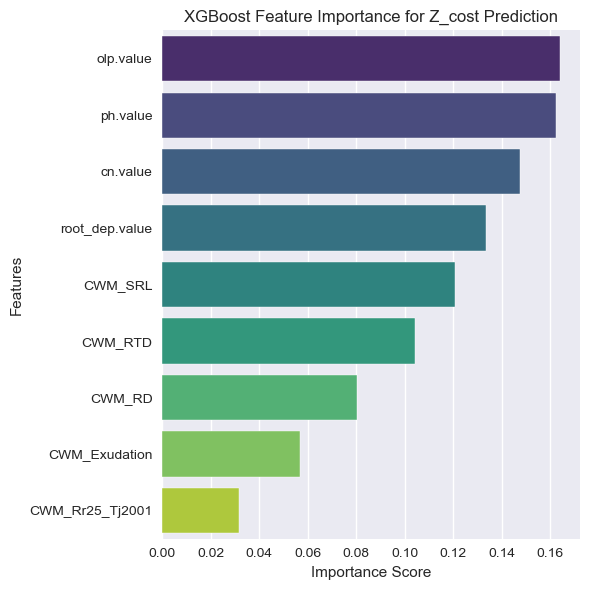

In [44]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': predictors,
    'importance': best_xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (XGBoost):")
display(feature_importance)

# Plot feature importance
plt.figure(figsize=(6, 6))
sns.barplot(data=feature_importance, y='feature', x='importance', palette='viridis')
plt.title('XGBoost Feature Importance for Z_cost Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

Feature Importance (Random Forest):


,feature,importance
8,cn.value,0.180742
6,olp.value,0.178983
7,ph.value,0.168343
5,root_dep.value,0.145582
2,CWM_SRL,0.099573
3,CWM_RTD,0.066400
0,CWM_Rr25_Tj2001,0.062390
1,CWM_RD,0.060027
4,CWM_Exudation,0.037960


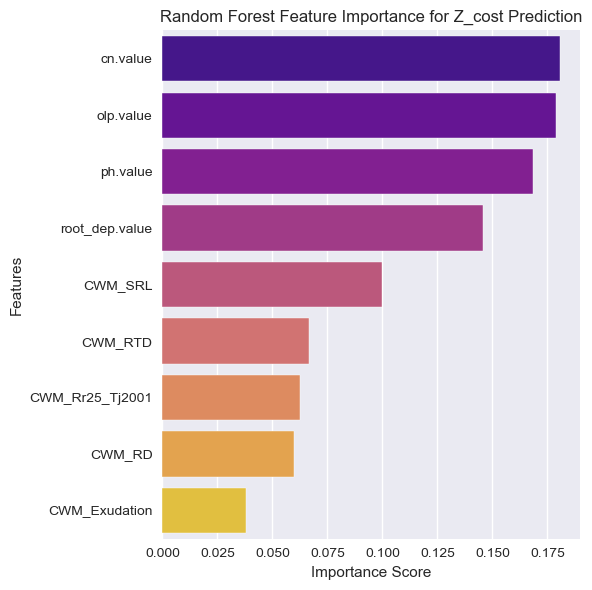

ValueError: 'facecolor' or 'color' argument must be a valid color orsequence of colors.

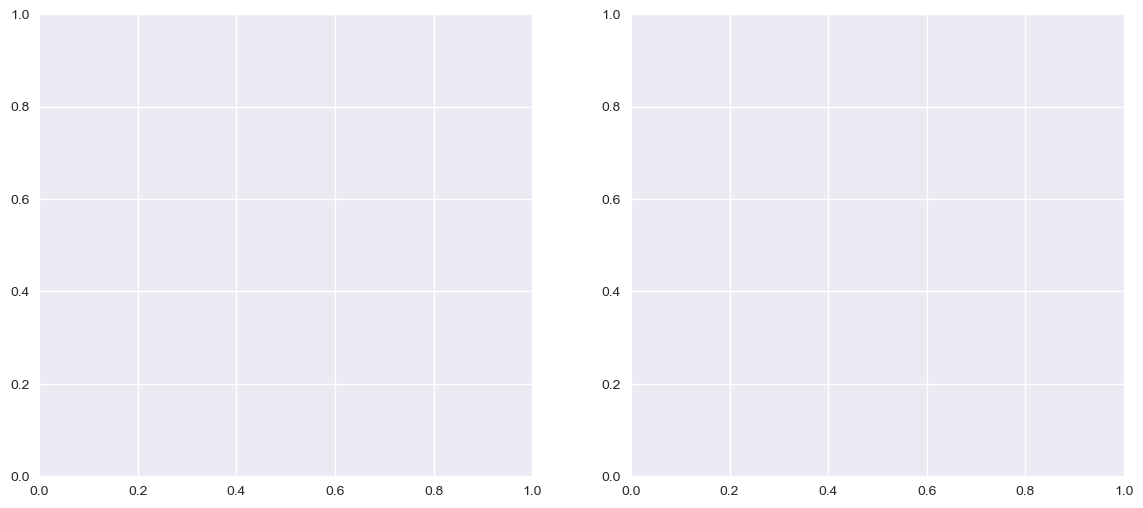

In [45]:
# Random Forest Feature Importance Analysis
rf_feature_importance = pd.DataFrame({
    'feature': predictors,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (Random Forest):")
display(rf_feature_importance)

# Plot Random Forest feature importance
plt.figure(figsize=(6, 6))
sns.barplot(data=rf_feature_importance, y='feature', x='importance', palette='plasma')
plt.title('Random Forest Feature Importance for Z_cost Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare feature importance between XGBoost and Random Forest
comparison_importance = pd.DataFrame({
    'feature': predictors,
    'xgboost_importance': best_xgb_model.feature_importances_,
    'rf_importance': rf_model.feature_importances_
})

# Create side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# XGBoost importance
feature_importance_sorted = comparison_importance.sort_values('xgboost_importance', ascending=True)
axes[0].barh(feature_importance_sorted['feature'], feature_importance_sorted['xgboost_importance'],
             color='viridis', alpha=0.8)
axes[0].set_title('XGBoost Feature Importance')
axes[0].set_xlabel('Importance Score')

# Random Forest importance
rf_importance_sorted = comparison_importance.sort_values('rf_importance', ascending=True)
axes[1].barh(rf_importance_sorted['feature'], rf_importance_sorted['rf_importance'],
             color='plasma', alpha=0.8)
axes[1].set_title('Random Forest Feature Importance')
axes[1].set_xlabel('Importance Score')

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 5 Features Comparison:")
print("XGBoost Top 5:")
for i in range(5):
    feat = feature_importance.iloc[i]['feature']
    imp = feature_importance.iloc[i]['importance']
    print(f"{i+1}. {feat}: {imp:.4f}")

print("\nRandom Forest Top 5:")
for i in range(5):
    feat = rf_feature_importance.iloc[i]['feature']
    imp = rf_feature_importance.iloc[i]['importance']
    print(f"{i+1}. {feat}: {imp:.4f}")

In [ ]:
# Model evaluation plots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# 2. Actual vs Predicted (Test)
axes[0].scatter(y_test, y_pred_test_best, alpha=0.6, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Z_cost')
axes[0].set_ylabel('Predicted Z_cost')
axes[0].set_title(f'Test Set: Actual vs Predicted\nR² = {best_test_r2:.4f}')

# 3. Residuals vs Predicted (Test)
residuals = y_test - y_pred_test_best
axes[1].scatter(y_pred_test_best, residuals, alpha=0.6, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Z_cost')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals vs Predicted (Test Set)')

plt.tight_layout()
plt.savefig('model_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

Performing cross-validation analysis...

Cross-Validation Results:


,Model,Mean_CV_R2,Std_CV_R2
0,XGBoost (Tuned),0.2480,0.0884
1,Random Forest,0.2453,0.0783
2,Linear Regression,-0.6236,0.8784


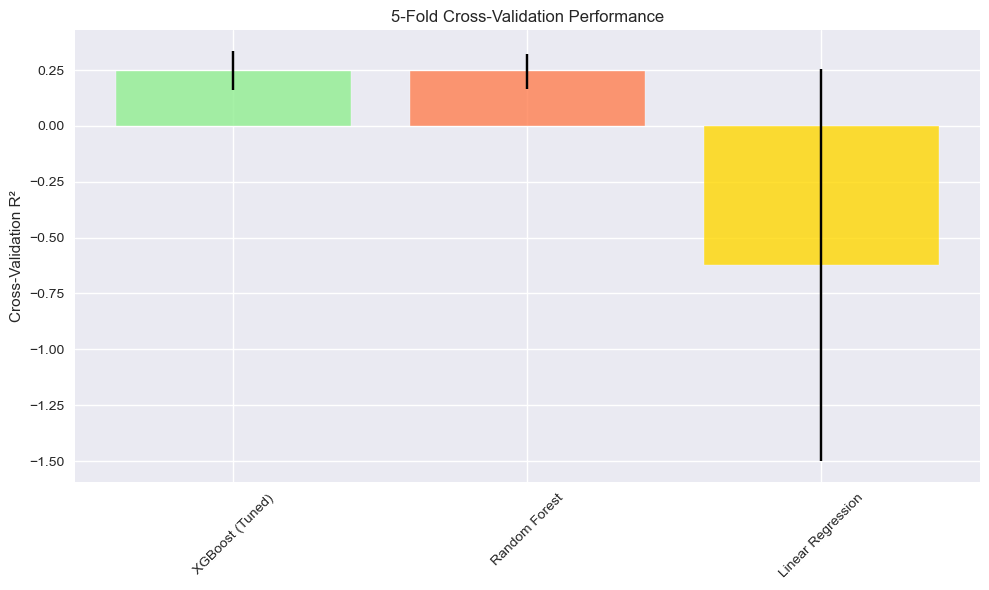

In [32]:
# Cross-validation analysis
print("Performing cross-validation analysis...")

# Cross-validation scores for different models
cv_scores_xgb = cross_val_score(best_xgb_model, X, y, cv=5, scoring='r2')
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
cv_scores_lr = cross_val_score(lr_model, scaler.fit_transform(X), y, cv=5, scoring='r2')

cv_results = pd.DataFrame({
    'Model': ['XGBoost (Tuned)', 'Random Forest', 'Linear Regression'],
    'Mean_CV_R2': [cv_scores_xgb.mean(), cv_scores_rf.mean(), cv_scores_lr.mean()],
    'Std_CV_R2': [cv_scores_xgb.std(), cv_scores_rf.std(), cv_scores_lr.std()]
})

print("\nCross-Validation Results:")
display(cv_results.round(4))

# Plot CV results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
models = cv_results['Model']
means = cv_results['Mean_CV_R2']
stds = cv_results['Std_CV_R2']

ax.bar(models, means, yerr=stds, capsize=5,
       color=['lightgreen', 'coral', 'gold'], alpha=0.8)
ax.set_ylabel('Cross-Validation R²')
ax.set_title('5-Fold Cross-Validation Performance')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('cv_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

/Users/edwardzhu/anaconda3/envs/IC-rf-py311/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/edwardzhu/anaconda3/envs/IC-rf-py311/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/edwardzhu/anaconda3/envs/IC-rf-py311/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2

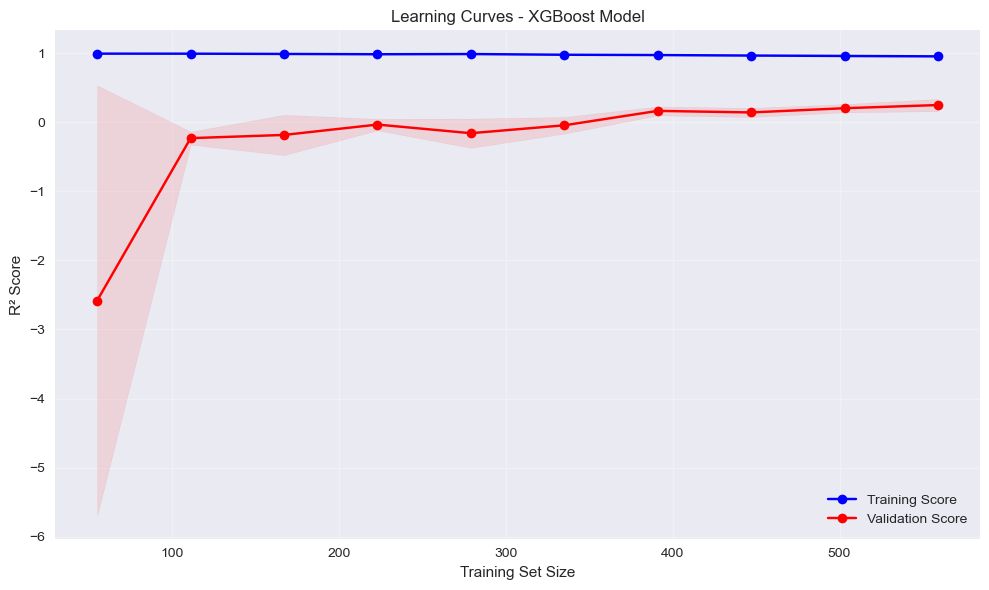

In [37]:
# Geographic analysis of predictions
# Add predictions to the test data
test_results = X_test.copy()
test_results['Actual_Z_cost'] = y_test
test_results['Predicted_Z_cost'] = y_pred_test_best
test_results['Residuals'] = test_results['Actual_Z_cost'] - test_results['Predicted_Z_cost']
test_results['Absolute_Error'] = np.abs(test_results['Residuals'])

# Learning curves
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_xgb_model, X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='r2'
)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', color='red', label='Validation Score')
plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color='blue')
plt.fill_between(train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                 np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title('Learning Curves - XGBoost Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model and results
import joblib

# Save the best model
joblib.dump(best_xgb_model, 'best_xgboost_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

# Save detailed results
results_summary = {
    'Model_Performance': {
        'Best_Test_R2': best_test_r2,
        'Best_Test_RMSE': best_test_rmse,
        'Best_Parameters': xgb_grid.best_params_
    },
    'Feature_Importance': feature_importance.to_dict('records'),
    'Model_Comparison': comparison_results.to_dict('records'),
    'Cross_Validation': cv_results.to_dict('records')
}

import json
with open('model_results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

# Save test predictions
test_results.to_csv('test_predictions.csv', index=False)